# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [71]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "/home/vitob/git_repositories/CarND-Traffic-Sign-Classifier-Project/train.p"
testing_file = "/home/vitob/git_repositories/CarND-Traffic-Sign-Classifier-Project/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy as np

### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = np.shape(X_train)[0]

# TODO: Number of testing examples.
# <<JC>> Interesting... len shows the first element of np.shape()
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train)[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

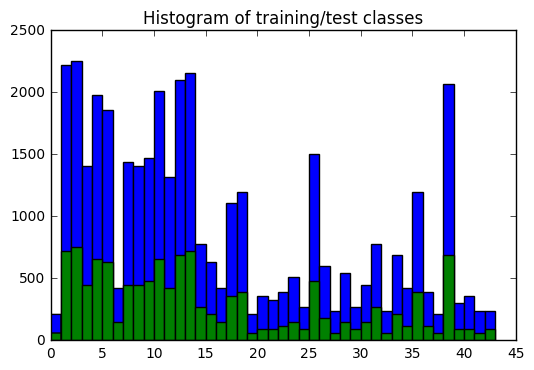

Snapshot of samples from training dataset:


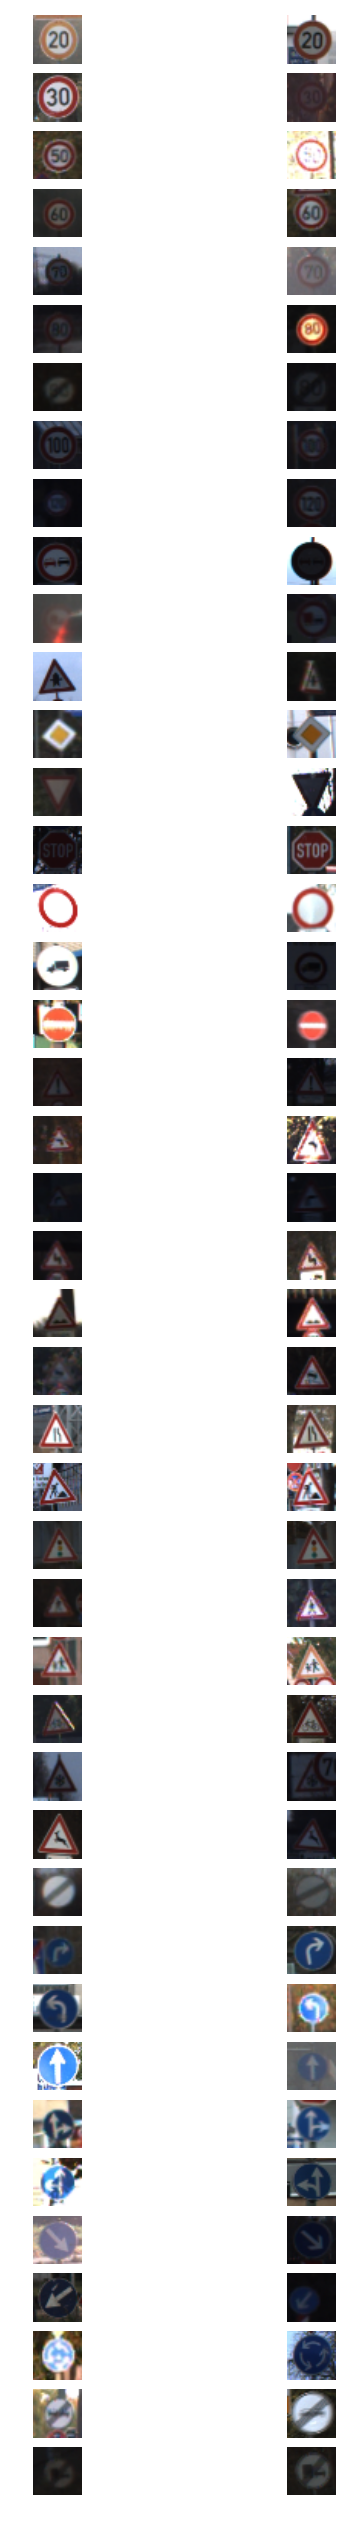

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

# Show histograms of all classes in training dataset
plt.hist(y_train,range(n_classes+1))
plt.hist(y_test,range(n_classes+1))
plt.title("Histogram of training/test classes")
plt.show()

# Show a random of n example of each class
samples_per_class = 2

plt.figure(figsize = (6,32))
print('Snapshot of samples from training dataset:')
for i in range(n_classes):
    #print(i)
    idxs = np.random.choice(np.flatnonzero(y_train==i), samples_per_class)
    for j , idx in enumerate(idxs):
        plt_idx = i*samples_per_class + j + 1
        plt.subplot(43, samples_per_class, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        
plt.show()
    
    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### 1. Data pre-processing:

##TODO : Create more data for general application
- Wrap images
- Add noises to images
- Image occlusion
- Brightness/Contrast 
- Scale of the traffic sign, but to a limit when shrinking.

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm

import os
import pickle
from sklearn.utils import shuffle

### Preprocess the data here.

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    img_max = np.max(image_data)
    img_min = np.min(image_data)
    a = 0.1
    b = 0.9

    img_normed = a + (b-a)*(image_data - img_min)/(img_max - img_min)
    #print(np.max(img_normed))
    #print(np.min(img_normed))
    return img_normed

def normalize_color(image_data):
    """
    Normalize the image data on per channel basis. 
    """
    img_normed_color = np.zeros_like(image_data, dtype=float)
    for ch in range(image_data.shape[3]):
        tmp = normalize_grayscale(image_data[:,:,:,ch])
        img_normed_color[:,:,:,ch] = tmp
    #print(np.max(img_normed_color))
    #print(np.min(img_normed_color))
    return img_normed_color

# Shuffle training data
X_train, y_train = shuffle(X_train, y_train)

# Image normalization
X_train_p = normalize_color(X_train)
X_test_p = normalize_color(X_test)

# Labels binarization encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train_p = encoder.transform(y_train)
y_test_p  = encoder.transform(y_test)

# Debug print - sanity check
#print("X_test_p.shape", X_test_p.shape)
#print("y_test_p.shape", y_test_p.shape)
#print("Before test splitting, X_train sample:", X_train_p[1])
#print("Before test splitting, X_test sample:", X_test_p[1])
#print("Before test splitting, np.max(X_train): ", np.max(X_train_p))
#print("Before test splitting, np.min(X_train): ", np.min(X_train_p))
#print("Before test splitting, np.max(X_test): ", np.max(X_test_p))
#print("Before test splitting, np.min(X_test): ", np.min(X_test_p))
#print("Before test splitting, y_train sample:", y_train_p[12])
#print("Before test splitting, y_test sample:", y_test_p[12])


# Split half test samples to be validation samples. - Reshuffle included already.
#Thus train/validation/test = 75%/12.5%/12.5%
X_valid_p, X_test_p, y_valid_p, y_test_p = train_test_split(
    X_test_p,
    y_test_p,
    test_size=0.5,
    random_state = 66)

# Debug print - sanity check
#print("After test splitting, X_train sample:", X_train_p[1])
#print("After test splitting, X_valid sample:", X_valid_p[1])
#print("After test splitting, X_test sample:", X_test_p[1])
#print("After test splitting, y_train sample:", y_train_p[12])
#print("After test splitting, y_valid sample:", y_valid_p[12])
#print("After test splitting, y_test sample:", y_test_p[12])
print("After test splitting, np.max(X_train): ", np.max(X_train_p))
print("After test splitting, np.min(X_train): ", np.min(X_train_p))
print("After test splitting, np.mean(X_train): ", np.mean(X_train_p))
print("After test splitting, X_train.dtype: ", X_train_p.dtype)

print("After test splitting, np.max(X_valid): ", np.max(X_valid_p))
print("After test splitting, np.min(X_valid): ", np.min(X_valid_p))
print("After test splitting, np.mean(X_valid): ", np.mean(X_valid_p))
print("After test splitting, X_valid.dtype: ", X_valid_p.dtype)

print("After test splitting, np.max(X_test): ", np.max(X_test_p))
print("After test splitting, np.min(X_test): ", np.min(X_test_p))
print("After test splitting, np.mean(X_test): ", np.mean(X_test_p))
print("After test splitting, X_test.dtype: ", X_test_p.dtype)

# Save the data for easy access
pickle_file = 'preprocessed.pickle'
if not os.path.isfile(pickle_file):
    print('Saving preprocessed data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train_p,
                    'train_labels': y_train_p,
                    'valid_dataset': X_valid_p,
                    'valid_labels': y_valid_p,
                    'test_dataset': X_test_p,
                    'test_labels': y_test_p,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')



After test splitting, np.max(X_train):  0.9
After test splitting, np.min(X_train):  0.1
After test splitting, np.mean(X_train):  0.357890414397
After test splitting, X_train.dtype:  float64
After test splitting, np.max(X_valid):  0.9
After test splitting, np.min(X_valid):  0.1
After test splitting, np.mean(X_valid):  0.354833402505
After test splitting, X_valid.dtype:  float64
After test splitting, np.max(X_test):  0.9
After test splitting, np.min(X_test):  0.1
After test splitting, np.mean(X_test):  0.354736124146
After test splitting, X_test.dtype:  float64
Data cached in pickle file.


### 2. Dataset class
- Retrieving pre-processed pickle file. 
- Function to load train/val/test batch.

In [5]:
import tensorflow as tf
import numpy as np
import pickle
import os

class dataset():
    """
    Dataset class to retrieve pickle file, and
    provide function to load train/val batch, test data.
    """
    def __init__(self):
        self.train_pointer = 0

    def reset_ptr(self):
        """
        Reset pointers for new epoch.
        """
        self.train_pointer = 0
        
    def open_dataset(self, file):
        self.f = open(file, 'rb')
        data = pickle.load(self.f)
        self.train_dataset = data['train_dataset']
        self.train_labels = data['train_labels']
        self.valid_dataset = data['valid_dataset']
        self.valid_labels = data['valid_labels']
        self.test_dataset = data['test_dataset']
        self.test_labels = data['test_labels']
        
        self.train_dataset_size = self.train_dataset.shape[0]
        #print("self.train_dataset_size =", self.train_dataset_size)
        
    def close_dataset(self):
        self.f.close()
        
    def load_train_batch(self, batch_size):
        if self.train_pointer + batch_size >= self.train_dataset_size:
            # At the end of training dataset items, less than batch_size requested
            batch = self.train_dataset_size
        else:
            # Get next batch_size out
            batch = self.train_pointer + batch_size
            
        X_out = self.train_dataset[self.train_pointer:batch,:,:,:]
        y_out = self.train_labels[self.train_pointer:batch]
        self.train_pointer = batch
        return X_out, y_out, self.train_pointer>=self.train_dataset_size
    
    def load_valid_data(self):
        # Test data doesn't need to be loaded in batches.
        return self.valid_dataset, self.valid_labels
    
    def load_test_data(self):
        # Test data doesn't need to be loaded in batches.
        return self.test_dataset, self.test_labels

    
# Load preprocessed data
file = 'preprocessed.pickle'
d = dataset()
d.open_dataset(file)
X_train_batch_1, y_train_batch_1, _ = d.load_train_batch(128)
for i in range(306): # Should report 40 training data, the last batch
    X_train_batch, y_train_batch, runout = d.load_train_batch(128)
    X_valid_batch, y_valid_batch = d.load_valid_data()
    X_test_dataset,  y_test_dataset  = d.load_test_data()

# Debug prints
#print("train_batch[2]=", X_train_batch[2])
#print("train_label[2]=", y_train_batch[2])
print("train_batch.shape = ", X_train_batch.shape)
print("max value in train_batch:", np.max(X_train_batch))
print("min value in train_batch:", np.min(X_train_batch))
print("mean value in train_reset:", np.mean(X_train_batch))
print("train_batch pointer = ", d.train_pointer)
assert runout==True, "ASSERT: Cannot read out all data in training set!!!"

print("validation_batch.shape = ", X_valid_batch.shape)
#print("valid_batch[2]=", X_valid_batch[2])
#print("valid_label[2]=", y_valid_batch[2])
print("max value in validation_batch:", np.max(X_valid_batch))
print("min value in validation_batch:", np.min(X_valid_batch))
print("mean value in validation_batch:", np.mean(X_valid_batch))

print("test_dataset.shape = ", X_test_dataset.shape)
#print("test_dataset[2]=", X_test_dataset[2])
#print("test_label[2]=", y_test_dataset[2])
print("max value in test_dataset:", np.max(X_test_dataset))
print("min value in test_dataset:", np.min(X_test_dataset))
print("mean value in test_dataset:", np.mean(X_test_dataset))

# Reset pointers test
print("Testing dataset.reset_ptr()...")
d.reset_ptr()
X_train_batch_reset, y_train_batch_reset, _ = d.load_train_batch(128)

print("train_batch_reset.shape = ", X_train_batch_reset.shape)
print("max value in train_batch_reset:", np.max(X_train_batch_reset))
print("min value in train_batch_reset:", np.min(X_train_batch_reset))
print("mean value in train_batch_reset:", np.mean(X_train_batch_reset))
print("train_batch pointer = ", d.train_pointer)

assert np.array_equal(X_train_batch_1, X_train_batch_reset), "dataset class reset_ptr() doesn't work!"
assert np.array_equal(y_train_batch_1, y_train_batch_reset), "dataset class reset_ptr() doesn't work!"

d.close_dataset()



train_batch.shape =  (41, 32, 32, 3)
max value in train_batch: 0.9
min value in train_batch: 0.103137254902
mean value in train_reset: 0.365054405814
train_batch pointer =  39209
validation_batch.shape =  (6315, 32, 32, 3)
max value in validation_batch: 0.9
min value in validation_batch: 0.1
mean value in validation_batch: 0.354833402505
test_dataset.shape =  (6315, 32, 32, 3)
max value in test_dataset: 0.9
min value in test_dataset: 0.1
mean value in test_dataset: 0.354736124146
Testing dataset.reset_ptr()...
train_batch_reset.shape =  (128, 32, 32, 3)
max value in train_batch_reset: 0.9
min value in train_batch_reset: 0.1
mean value in train_batch_reset: 0.366120952137
train_batch pointer =  128


### 3. TSC_Net class

The Traffic Sign Classifier (TSC) Neural Network implemention.

In [73]:
import os
import sys
from tensorflow.contrib.layers import flatten

LOG_DIR = './tensorboard_log/LeNet'
MODEL_DIR =  './model'

TRAIN_DROPOUT = 0.5 
TEST_DROPOUT = 1.0
LEARNING_RATE = 1e-6


class tsc_net():
    """
    Traffic Sign Classification Network class. Derived from LeNet example.
    """
    
    def __init__(self):
        self.create_tsc_net()
        self.create_tf()
        
        self.session = tf.InteractiveSession()
        
        # Merge all summaries and write them out
        self.merged_summaries = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, "train"), self.session.graph)
        self.test_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, "test"))
    
        # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
        tf.global_variables_initializer()

    def weight_variable(self,shape,stddev=0.1):
        initial = tf.truncated_normal(shape,stddev=stddev)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)

    def conv2d(self, x, W, b, strides=1):
        # Conv2D wrapper, writh bias and relu activation
        x = tf.nn.conv2d(x, W, strides=[1,strides,strides,1], padding='VALID')
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x)
    
    def create_tsc_net(self):   
        """
        Create the tensorflow based layers, cost, optimizer, etc. 
        """
        # Hyperparameters
        mu = 0
        sigma = 0.1
        
        with tf.name_scope("input_layer"):
            # Input layer: [batch_size, 32, 32, 3] - TODO: Tensorflow doesn't support tf.float64 yet.
            self.img_in = tf.placeholder(tf.float32, [None, 32, 32, 3])
            tf.summary.histogram("input_img", self.img_in)
            
        with tf.name_scope("layer1_conv"):
            # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
            conv1_W = self.weight_variable(shape=[5, 5, 3, 6], stddev=sigma)
            conv1_b = self.bias_variable(shape=[6])
            conv1   = self.conv2d(self.img_in, conv1_W, conv1_b)
            tf.summary.histogram("conv1_W", conv1_W)
            tf.summary.histogram("conv1_b", conv1_b)
            tf.summary.histogram("conv1", conv1)
            # Pooling. Input = 28x28x6. Output = 14x14x6.
            conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        with tf.name_scope("layer2_conv"):
            # Layer 2: Convolutional. Output = 10x10x16.
            conv2_W = self.weight_variable(shape=[5, 5, 6, 16], stddev = sigma)
            conv2_b = self.bias_variable(shape=[16])
            conv2   = self.conv2d(conv1, conv2_W, conv2_b)
            tf.summary.histogram("conv2_W", conv2_W)
            tf.summary.histogram("conv2_b", conv2_b)
            tf.summary.histogram("conv2", conv2)
            # Pooling. Input = 10x10x16. Output = 5x5x16.
            conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flatten. Input = 5x5x16. Output = 400.
        fc0 = flatten(conv2)

        with tf.name_scope("layer3_fc"):
            # Layer 3: Fully Connected. Input = 400. Output = 120.
            fc1_W = self.weight_variable(shape=[400, 120], stddev = sigma)
            fc1_b = self.bias_variable(shape=[120])
            fc1   = tf.matmul(fc0, fc1_W) + fc1_b
            # Activation.
            fc1    = tf.nn.relu(fc1)
            tf.summary.histogram("fc1_W", fc1_W)
            tf.summary.histogram("fc1_b", fc1_b)
            tf.summary.histogram("fc1", fc1)
            
        with tf.name_scope("layer4_fc"):
            # Layer 4: Fully Connected. Input = 120. Output = 84.
            fc2_W  = self.weight_variable(shape=[120, 84], stddev = sigma)
            fc2_b  = self.bias_variable(shape=[84])
            fc2    = tf.matmul(fc1, fc2_W) + fc2_b
            # Activation.
            fc2    = tf.nn.relu(fc2)
            tf.summary.histogram("fc2_W", fc2_W)
            tf.summary.histogram("fc2_b", fc2_b)
            tf.summary.histogram("fc2", fc2)
            
        with tf.name_scope("layer5_fc"):
            # Layer 5: Fully Connected. Input = 84. Output = 43.
            fc3_W  = self.weight_variable(shape=[84, 43], stddev = sigma)
            fc3_b  = self.bias_variable(shape=[43])
            self.logits = tf.matmul(fc2, fc3_W) + fc3_b
            tf.summary.histogram("fc3_W", fc3_W)
            tf.summary.histogram("fc3_b", fc3_b)
            tf.summary.histogram("logits", self.logits)
            
    def create_tf(self):
        """
        Loss/accuracy function and optimizer definition.
        """
        self.label_truth = tf.placeholder(tf.float32, [None,43])
        self.loss = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.label_truth)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(self.loss)
        
        #self.prediction = tf.nn.softmax(self.logits)        
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.logits, 1), 
                                    tf.argmax(self.label_truth, 1)), tf.float32))
        
        tf.summary.scalar('loss', self.loss)
        tf.summary.scalar('accuracy', self.accuracy)
        
    def train(self,X,y,i):
        summary, _, loss = self.session.run(
                [self.merged_summaries, self.optimizer, self.loss],
                feed_dict={
                    #self.img_in: tf.cast(X, tf.float32), # TF doesn't support float64 yet.
                    self.img_in: X.astype(np.float32), # TF doesn't support float64 yet.
                    self.label_truth: y.astype(np.float32) # y is int64 in my system
                })
        # Record summary every N batches
        if i%10 == 0:
            self.train_writer.add_summary(summary, i)

    def val(self,X,y,i):
        accuracy = self.session.run(
                [self.accuracy],
                feed_dict={
                    #self.img_in: tf.cast(X, tf.float32), # TF doesn't support float64 yet.
                    self.img_in: X.astype(np.float32), # TF doesn't support float64 yet.
                    self.label_truth: y.astype(np.float32) # y is int64 in my system
                })
        print('val: step %{2d}, accuracy %{5.3f}'.format(i, accuracy))
        self.val_writer.add_summary(summary, i)
        
    def saveParam(self):
        if not os.path.exists(MODEL_DIR):
            os.makedirs(MODEL_DIR)
        checkpoint_path = os.path.join(MODEL_DIR, "model.ckpt")
        filename = self.saver.save(self.session, checkpoint_path)
        print("Model saved in file: %s" % filename)

    def restoreParam(self):
        if not os.path.exists(MODEL_DIR):
            sys.exit("No such dir to restore parameters! Exiting.")
        checkpoint_path = os.path.join(MODEL_DIR, "model.ckpt")
        self.saver.restore(self.session, checkpoint_path)
        print("Model restored from file: %s" % checkpoint_path)

### 4. Stitching everthing together

In [75]:
def main():
    mynet = tsc_net()
    data = dataset()
    
    file = 'preprocessed.pickle'

    data.open_dataset(file)

    X_train_batch, y_train_batch, end_of_train_dataset = data.load_train_batch(128)
    print("X_train_batch.shape = ", np.shape(X_train_batch))
    print("X_train_batch.dtype = ", X_train_batch.dtype)
    print("y_train_batch.shape = ", np.shape(y_train_batch))
    print("y_train_batch.dtype = ", y_train_batch.dtype)
    mynet.train(X_train_batch, np.zeros([128,43], dtype=np.float32), 1)
    #mynet.train(X_train_batch, y_train_batch.astype(np.float32), 1)
    X_valid_dataset, y_valid_dataset = data.load_valid_data()
    mynet.val(X_valid_dataset, y_valid_dataset, 1)
    X_test_dataset,  y_test_dataset  = data.load_test_data()
    mynet.val(X_test_dataset, y_test_dataset, 1)

    # Reset pointers test
    print("Testing dataset.reset_ptr()...")
    data.reset_ptr()
    X_train_batch, y_train_batch, end_of_train_dataset = data.load_train_batch(128)
    mynet.train(X_train_batch, y_train_batch, 1)
    data.close_dataset()

if __name__ == '__main__':
    main()

X_train_batch.shape =  (128, 32, 32, 3)
X_train_batch.dtype =  float64
y_train_batch.shape =  (128, 43)
y_train_batch.dtype =  int64


InvalidArgumentError: You must feed a value for placeholder tensor 'input_layer_29/Placeholder' with dtype float
	 [[Node: input_layer_29/Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: input_layer_1/Placeholder/_1185 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3732_input_layer_1/Placeholder", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_layer_29/Placeholder', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-65-e4e0f70a5d4f>", line 28, in <module>
    main()
  File "<ipython-input-65-e4e0f70a5d4f>", line 2, in main
    mynet = tsc_net()
  File "<ipython-input-64-ef2c28707a85>", line 19, in __init__
    self.create_tsc_net()
  File "<ipython-input-64-ef2c28707a85>", line 56, in create_tsc_net
    self.img_in = tf.placeholder(tf.float32, [None, 32, 32, 3])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_layer_29/Placeholder' with dtype float
	 [[Node: input_layer_29/Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: input_layer_1/Placeholder/_1185 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3732_input_layer_1/Placeholder", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

- I had met an error when creating array as foo=np.zeros_like(). Normed_image contains floating point data while np.zeros_like() creates int data type, thus when I assigned foo = normed_image, foo is always 0. Fixed by np.zeros_like(image, dtype=float).

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.